In [ ]:
!pip install opendatasets

In [ ]:
import os
import cv2
import numpy as np
import opendatasets as od
from tqdm.notebook import tqdm
from PIL import Image

import tarfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets.utils import download_url, extract_archive

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

In [ ]:
def get_default_device():
    """Get the default device for PyTorch."""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(data, device):
    """Move data to the specified device."""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wraps a DataLoader to move data to a specified device."""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for data in self.dl:
            yield to_device(data, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
project_name = 'anime_dcgan'

In [ ]:
dataset_url = "https://www.kaggle.com/datasets/splcher/animefacedataset"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dhandeepsingh
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:01<00:00, 282MB/s]


In [ ]:
data_dir = './animefacedataset'

In [ ]:
os.listdir(data_dir)

['images']

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
])
train_ds = ImageFolder(data_dir, transform=train_transform)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
train_dl = DeviceDataLoader(train_dl, device)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def denorm(tensor):
    """Denormalize a tensor image."""
    mean = torch.tensor(stats[0]).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(stats[1]).view(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0).cpu())

In [ ]:
def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        plt.show()
        break

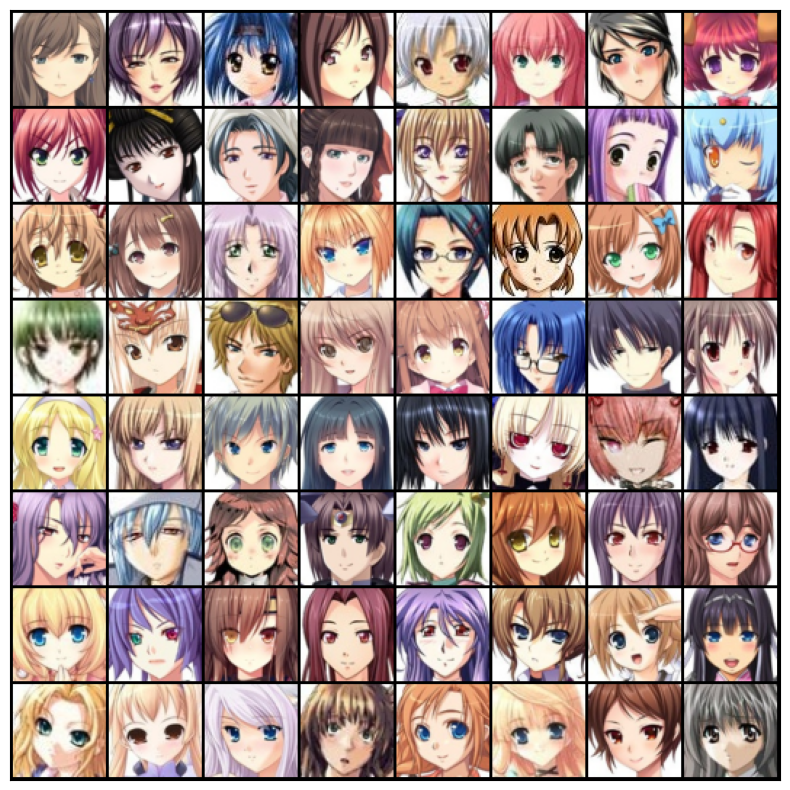

In [ ]:
show_batch(train_dl)

In [ ]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),  # 64x32x32
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),  # 128x16x16
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256x8x8
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 512x4x4
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),  # Output: 1x1x1

    nn.Flatten(),
    nn.Sigmoid()
)
discriminator = to_device(discriminator, device)

In [ ]:
noise_size = 128
generator = nn.Sequential(
    # Input: 128x1x1
    nn.ConvTranspose2d(noise_size, 512, kernel_size=4, stride=1, padding=0, bias=False),  # 512x4x4
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),  # 256x8x8
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # 128x16x16
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),  # 64x32x32
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),  # 3x64x64
    nn.Tanh()
)
generator = to_device(generator, device)

torch.Size([128, 3, 64, 64])


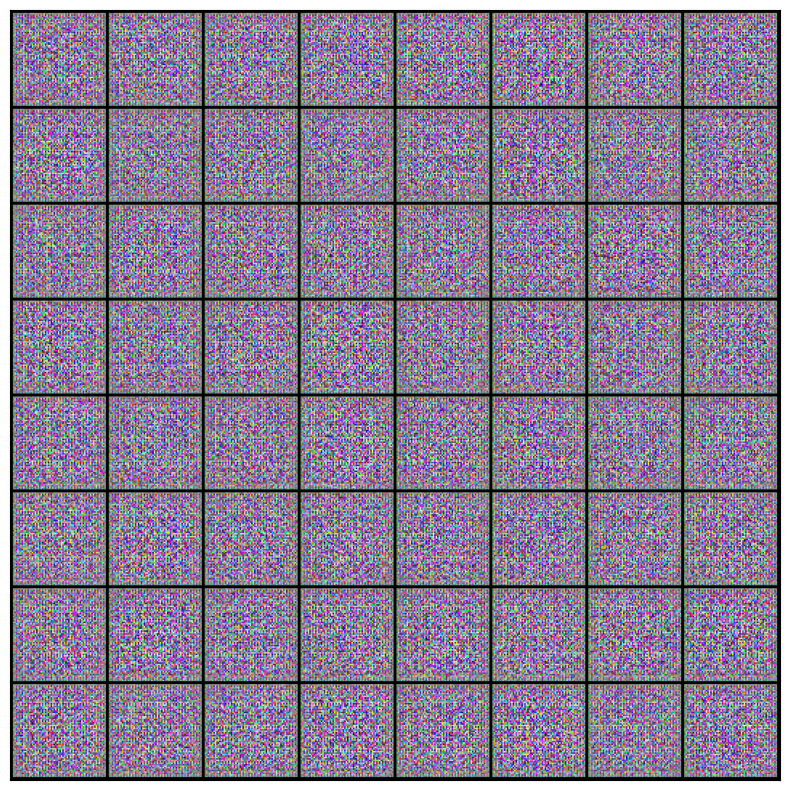

In [ ]:
xb = torch.randn(batch_size, noise_size, 1, 1, device=device)
generated_images = generator(xb)
print(generated_images.shape)
show_images(generated_images, nmax=64)

In [ ]:
def train_discriminator(real_images, optimizer_d):
    optimizer_d.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    noise = torch.randn(batch_size, noise_size, 1, 1, device=device)
    generated_images = generator(noise)

    generated_preds = discriminator(generated_images)
    generated_targets = torch.zeros(batch_size, 1, device=device)
    generated_loss = F.binary_cross_entropy(generated_preds, generated_targets)
    generated_score = torch.mean(generated_preds).item()

    loss = real_loss + generated_loss
    loss.backward()
    optimizer_d.step()

    return loss.item(), real_score, generated_score

In [ ]:
def train_generator(optimizer_g):
    optimizer_g.zero_grad()

    noise = torch.randn(batch_size, noise_size, 1, 1, device=device)
    generated_images = generator(noise)

    preds = discriminator(generated_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    loss.backward()
    optimizer_g.step()
    # score = torch.mean(preds).item()

    return loss.item()

In [ ]:
sample_dir = "generated_images"
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, noise_tensors, show=True):
    fake_images = generator(noise_tensors)
    fake_fname = 'generated-image-{0:04d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print(f"Saved {fake_fname}")
    if show:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_noise = torch.randn(64, noise_size, 1, 1, device=device)

Saved generated-image-0000.png


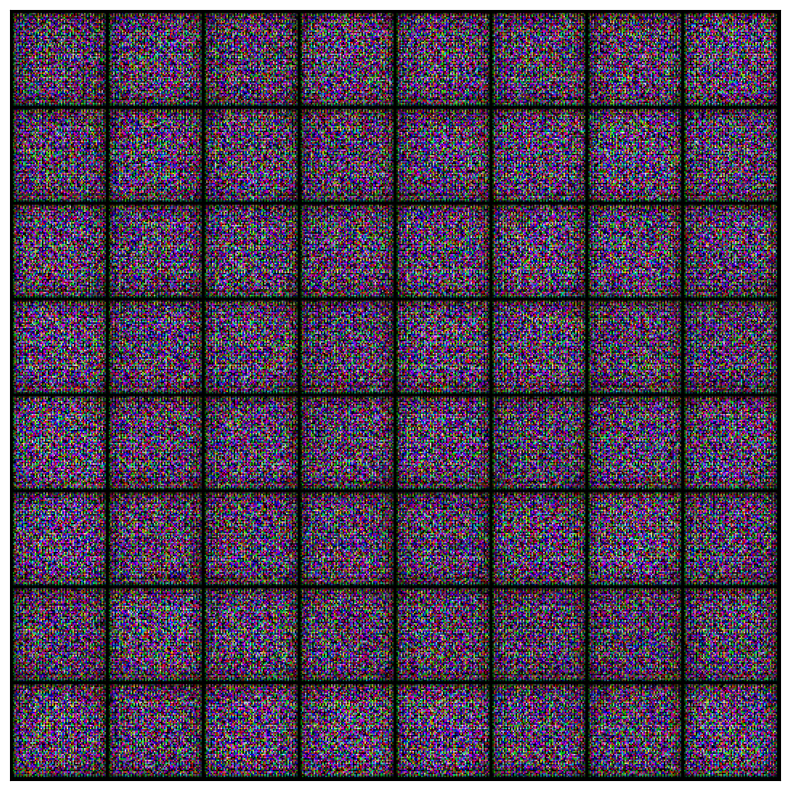

In [ ]:
save_samples(0, fixed_noise)

In [ ]:
def train(epochs, lr, start_index=1):
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            real_images = real_images.to(device)
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)

            losses_d.append(loss_d)
            losses_g.append(loss_g)
            real_scores.append(real_score)
            fake_scores.append(fake_score)

        print(f"Epoch [{epoch+1}/{epochs}], Loss D: {loss_d:.4f}, Loss G: {loss_g:.4f}, Real Score: {real_score:.4f}, Fake Score: {fake_score:.4f}")

        save_samples(epoch + start_index, fixed_noise, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 25

In [ ]:
training = train(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], Loss D: 0.8900, Loss G: 5.6085, Real Score: 0.9817, Fake Score: 0.5430
Saved generated-image-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], Loss D: 1.3761, Loss G: 9.1592, Real Score: 0.9715, Fake Score: 0.6962
Saved generated-image-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], Loss D: 0.2839, Loss G: 4.4046, Real Score: 0.8562, Fake Score: 0.1018
Saved generated-image-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], Loss D: 0.1740, Loss G: 4.7837, Real Score: 0.9203, Fake Score: 0.0793
Saved generated-image-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], Loss D: 0.2300, Loss G: 9.5975, Real Score: 0.9967, Fake Score: 0.1719
Saved generated-image-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], Loss D: 0.0923, Loss G: 6.3903, Real Score: 0.9870, Fake Score: 0.0731
Saved generated-image-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], Loss D: 0.1471, Loss G: 5.1767, Real Score: 0.8901, Fake Score: 0.0105
Saved generated-image-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], Loss D: 0.0766, Loss G: 7.4205, Real Score: 0.9428, Fake Score: 0.0040
Saved generated-image-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], Loss D: 0.1515, Loss G: 8.2132, Real Score: 0.9761, Fake Score: 0.1078
Saved generated-image-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], Loss D: 0.1186, Loss G: 5.9337, Real Score: 0.9478, Fake Score: 0.0391
Saved generated-image-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], Loss D: 0.0879, Loss G: 4.9547, Real Score: 0.9345, Fake Score: 0.0071
Saved generated-image-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], Loss D: 0.0467, Loss G: 8.0432, Real Score: 0.9826, Fake Score: 0.0026
Saved generated-image-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], Loss D: 0.0695, Loss G: 4.9745, Real Score: 0.9577, Fake Score: 0.0154
Saved generated-image-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], Loss D: 0.0515, Loss G: 7.1624, Real Score: 0.9924, Fake Score: 0.0406
Saved generated-image-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], Loss D: 0.0192, Loss G: 7.4423, Real Score: 0.9933, Fake Score: 0.0117
Saved generated-image-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], Loss D: 0.1078, Loss G: 9.3279, Real Score: 0.9878, Fake Score: 0.0871
Saved generated-image-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], Loss D: 0.0606, Loss G: 5.0041, Real Score: 0.9742, Fake Score: 0.0259
Saved generated-image-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], Loss D: 0.0615, Loss G: 6.7525, Real Score: 0.9551, Fake Score: 0.0053
Saved generated-image-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], Loss D: 0.2043, Loss G: 9.4091, Real Score: 0.8900, Fake Score: 0.0011
Saved generated-image-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], Loss D: 0.0568, Loss G: 7.7939, Real Score: 0.9819, Fake Score: 0.0357
Saved generated-image-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], Loss D: 0.0164, Loss G: 7.1628, Real Score: 0.9985, Fake Score: 0.0146
Saved generated-image-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], Loss D: 0.0918, Loss G: 5.0243, Real Score: 0.9512, Fake Score: 0.0279
Saved generated-image-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], Loss D: 0.8986, Loss G: 13.1655, Real Score: 1.0000, Fake Score: 0.3250
Saved generated-image-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], Loss D: 0.0485, Loss G: 5.8787, Real Score: 0.9771, Fake Score: 0.0226
Saved generated-image-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], Loss D: 0.1034, Loss G: 5.8284, Real Score: 0.9587, Fake Score: 0.0521
Saved generated-image-0025.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = training

In [ ]:
vid_fname = 'gans_training.mp4'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 1, (530, 530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

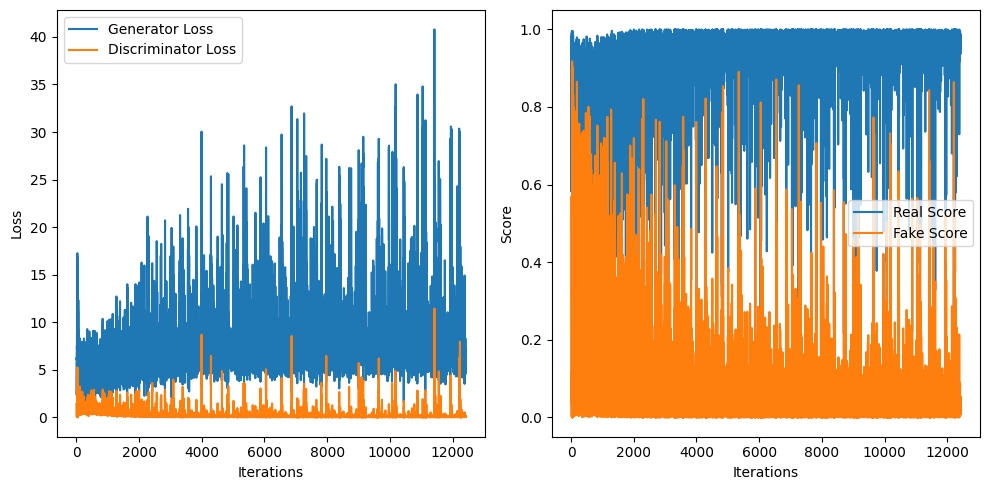

In [ ]:
# plotting the losses and scores
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(losses_g, label='Generator Loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(real_scores, label='Real Score')
plt.plot(fake_scores, label='Fake Score')
plt.xlabel('Iterations')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

In [ ]:
import shutil
import os

folder_to_zip = 'generated_images'
zip_filename = 'generated_images.zip'

if os.path.exists(folder_to_zip):
    shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', folder_to_zip)
    print(f"Folder '{folder_to_zip}' successfully zipped to '{zip_filename}'.")
else:
    print(f"Folder '{folder_to_zip}' not found.")

Folder 'generated_images' successfully zipped to 'generated_images.zip'.


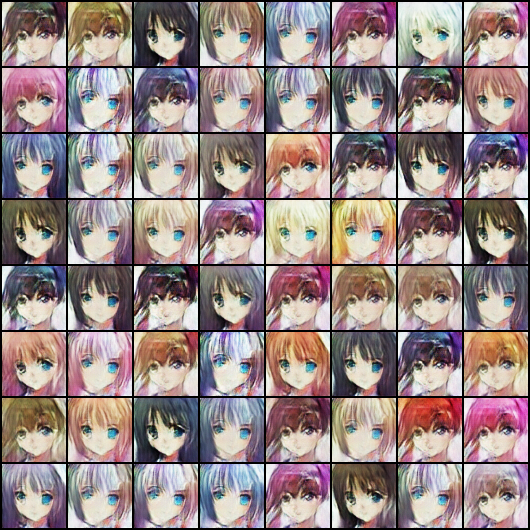

In [ ]:
from PIL import Image

try:
    img = Image.open('generated_images/generated-image-0025.png')
    display(img)
except FileNotFoundError:
    print("The file 'generated_images/generated-image-0001.png' was not found. Please check the path and filename.")